Re-training Resnet50 with 5 classes in order to get ordered, numbered folders. I found that the wormDataset wasn't always bringing the folders in in the same order as the class numbering system, which is just MASSIVELY annoying to deal with when using the model - the prediction indices don't nicely correspond to the classes.

In [1]:
# Quick check to see how many images there are per class

def count_images(file_path):
    # Finds class folders, makes a list of classes, and counts how many images are in each class
    import os
    from pathlib import Path
    
    image_counter = []
    class_names = []
    
    for class_name in sorted(os.listdir(file_path)):
        # Exclude .DS_Store
        if class_name != '.DS_Store':
            
            class_names.append(class_name)

            # Make a Path to the class directory
            class_dir = Path(file_path) / class_name

            # Note that this is set to work with .png images and needs modification
            # to work with other types
            image_counter.append(len(os.listdir(class_dir)))
                          
    return image_counter, class_names

In [2]:
train_path = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/train'
train_counts, class_names = count_images(train_path)
print(class_names)
print(train_counts)

['0', '1', '2', '3', '4']
[298, 95, 57, 95, 310]


In [3]:
test_path = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/test'
test_counts, class_names = count_images(test_path)
print(class_names)
print(test_counts)

['0', '1', '2', '3', '4']
[292, 100, 60, 100, 348]


In [4]:
# Import the image processing functions and class
from image_import import process_image, de_process_image, wormDataset

# Import all needed libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
# These last two are used to save info about how the training progressed
import pickle
import datetime

# Set the full path to the main image directory
train_dir = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/train'
test_dir = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/test'
num_train = 10
num_test = 10

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

traindata = wormDataset(train_dir, means, stds)
testdata = wormDataset(test_dir, means, stds)

# Load from the training and test sets
trainloader = torch.utils.data.DataLoader(traindata, batch_size=num_train, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=num_test, shuffle=True)

# Get the classes
class_names = traindata.classes
print('Detected ' + str(len(class_names)) + ' classes in training data')
print(class_names)

# Print out how many images are in the trainloader and testloader
print("Train batch size = " + str(num_train) + ', test batch size = ' + str(num_test))
print('Trainloder length = ' + str(len(trainloader)) + ', testloader length = ' + str(len(testloader)))

Detected 5 classes in training data
['0', '1', '2', '3', '4']
Train batch size = 10, test batch size = 10
Trainloder length = 86, testloader length = 90


In [6]:
%%capture 
# Prevent printing out the model architecture
# Check if cuda is available, and set pytorch to run on GPU or CPU as appropriate
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Cuda available, running on GPU')
else:
    device = torch.device("cpu")
    print('Cuda is not available, running on CPU')
    # Give the user a message so they know what is going on

model = models.resnet50(pretrained=True)
#print(model) 
# Printing the model shows some of the internal layers, not expected to
# understand these but neat to see

# Freeze the pre-trained layers, no need to update featue detection
for param in model.parameters():
    param.requires_grad = False

# Get the number of features the model expects in the final fully connected layer, this is different
# in different models
num_ftrs = model.fc.in_features

# Re-define the final fully connected layer (model.fc, fc = fully connected)
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512), # 2048 inputs to 512 outputs 
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 # The next line needs to be modified for the number of classes
                                 # in the data set. For the microscope images I currently have 
                                 # five classes, so there are 5 outputs
                                 nn.Linear(512, 5), # 512 inputs to 5 outputs
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

In [7]:
# Train the network
epochs = 2
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses, accuracy_tracker = [], [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader)) 
            accuracy_tracker.append(accuracy/len(testloader))                     
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'resnet50_5cat.pth')

Epoch 1/2.. Train loss: 2.895.. Test loss: 1.266.. Test accuracy: 0.736
Epoch 1/2.. Train loss: 1.196.. Test loss: 0.838.. Test accuracy: 0.697
Epoch 1/2.. Train loss: 0.705.. Test loss: 0.669.. Test accuracy: 0.764
Epoch 1/2.. Train loss: 0.765.. Test loss: 0.701.. Test accuracy: 0.747
Epoch 1/2.. Train loss: 0.794.. Test loss: 0.594.. Test accuracy: 0.743
Epoch 1/2.. Train loss: 0.546.. Test loss: 0.530.. Test accuracy: 0.733
Epoch 1/2.. Train loss: 0.592.. Test loss: 0.545.. Test accuracy: 0.808
Epoch 1/2.. Train loss: 0.563.. Test loss: 0.407.. Test accuracy: 0.853
Epoch 2/2.. Train loss: 0.685.. Test loss: 0.673.. Test accuracy: 0.741
Epoch 2/2.. Train loss: 0.786.. Test loss: 0.412.. Test accuracy: 0.848
Epoch 2/2.. Train loss: 0.764.. Test loss: 0.522.. Test accuracy: 0.777
Epoch 2/2.. Train loss: 0.536.. Test loss: 0.340.. Test accuracy: 0.868
Epoch 2/2.. Train loss: 0.547.. Test loss: 0.411.. Test accuracy: 0.814
Epoch 2/2.. Train loss: 0.806.. Test loss: 0.353.. Test accuracy

In [8]:
# Save the information about how training went
# Get a unique date and time to id this training round
now = datetime.datetime.now()
time_string = ('-').join([str(now.hour), str(now.minute)]) 
date_string = ('-').join([str(now.month), str(now.day), str(now.year)])
file_name = ('_').join(['resnet50_5cat_training', date_string, time_string])

fileObject = open(file_name, 'wb')
training_data = [train_losses, test_losses, accuracy_tracker]
pickle.dump(training_data, fileObject)
fileObject.close
fileObject.close()

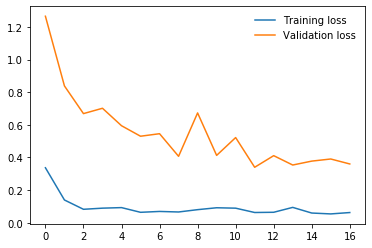

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [10]:
# Evaluate on all images in the test loader
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on ' + str(total) + ' test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on 900 test images: 74 %


In [11]:
# Evaluate on all images in the test loader
confusion_matrix = np.zeros((5, 5))

class_names = testdata.classes

with torch.no_grad():
    for data in testloader:
        # This is processing in batches, the number of things in images and labels is the
        # the same as the batch size
        images, labels = data
        outputs = model(images)
        predicted = torch.max(outputs.data, 1)
        num_labels = labels.size(0)
        total += num_labels
        for i in range(num_labels): # Iterate through the labels in the batch
            
            # Increase the cell corresponding to the label / prediction pair by one
            confusion_matrix[labels[i], predicted.indices[i]] += 1
            
print(confusion_matrix)

[[275.   2.   0.   0.  15.]
 [ 45.  24.   1.   2.  28.]
 [  3.  23.   2.   4.  28.]
 [  1.   8.   1.  13.  77.]
 [  0.   1.   0.   1. 346.]]


In [12]:
# Validation check by adding up the rows and seeing if this matches the true image counts from the folder
print('Images in folders:')
print(test_counts)
print('')

print('Labels in Confusion Matrix:')
print(np.sum(confusion_matrix, axis=1))

Images in folders:
[292, 100, 60, 100, 348]

Labels in Confusion Matrix:
[292. 100.  60. 100. 348.]


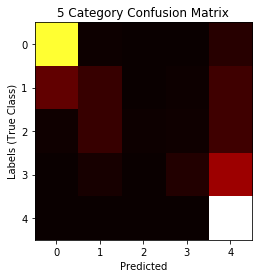

In [14]:
# Make a nicer version of the confusion matrix with axis labels
plt.title('5 Category Confusion Matrix')
plt.ylabel('Labels (True Class)')
plt.xlabel('Predicted')
plt.imshow(confusion_matrix, cmap='hot', interpolation='nearest')
plt.show()

In [15]:
# Percent accurate
percent_accurate = np.sum(np.diagonal(confusion_matrix)) / np.sum(confusion_matrix) * 100
print(percent_accurate)

73.33333333333333


In [16]:
# Row 2 is true acceptable, column 2 is predicted acceptable
# Errors in which an acceptable image is mistaken for out of focus
(np.sum(confusion_matrix[2,:]) - confusion_matrix[2,2]) / np.sum(confusion_matrix) * 100

6.444444444444445

In [17]:
# Errors in which an out of focus image is mistaken for acceptable
(np.sum(confusion_matrix[:,2]) - confusion_matrix[2,2]) / np.sum(confusion_matrix) * 100

0.2222222222222222

The model is MUCH more likely to mistake an out of focus image for acceptable than to mistake an in-focus image for acceptable. This may be a result of bias in the sample, there are many more out of focus images compared to in focus (3 acceptable in a stack of 44)

In [27]:
# Percent of failure errors
percent_failure = (np.sum(confusion_matrix[2,:]) + np.sum(confusion_matrix[:,2]) - (2 * confusion_matrix[2,2])) / np.sum(confusion_matrix) * 100
print(percent_failure)

6.666666666666667


In [19]:
# Errors in which the predicted class is a neighbor of the true class
# Subset the confusion matrix and take the diagonals to get the cells on either side of the main diagonal
# (one class off vs. accurate predictions)
neighbors_pos = np.diagonal(confusion_matrix[1:, :6])
np.sum(neighbors_pos) / np.sum(confusion_matrix) * 100

7.777777777777778

In [20]:
neighbors_neg = np.diagonal(confusion_matrix[:6, 1:])
np.sum(neighbors_neg) / np.sum(confusion_matrix) * 100

9.333333333333334

In [21]:
percent_neighbor = (np.sum(neighbors_pos) + np.sum(neighbors_neg)) / np.sum(confusion_matrix) * 100 
print(percent_neighbor)

17.11111111111111


In [22]:
# Errors in which the model gets the direction wrong
# Thinks the plane of focus is above best focus when it is below, and vice-versa
# These are on the upper right to lower left diagonal, get this by flipping the array
np.diagonal(np.fliplr(confusion_matrix))

array([15.,  2.,  2.,  8.,  0.])

This particular model has a higher rate of "opposite" errors than seen in some other training rounds. These are errors in which the model classes an image as above the optimal focal plane when it is really below, and vice-versa. The largest number of these are in the upper right hand corner, this corresponds to very out below getting classes as very out above.

In [23]:
percent_opposite = (np.sum(np.diagonal(np.fliplr(confusion_matrix))) - confusion_matrix[2,2]) / np.sum(confusion_matrix) * 100
print(percent_opposite)

1.5555555555555556


In [28]:
percent_other = 100 - percent_failure - percent_neighbor - percent_opposite - percent_accurate
print(percent_other)

1.3333333333333286


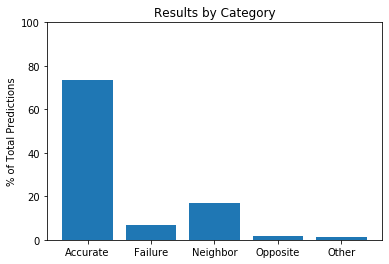

In [29]:
bars = ['Accurate', 'Failure', 'Neighbor', 'Opposite', 'Other']
y_pos = np.arange(len(bars))
plt.bar(y_pos, [percent_accurate, percent_failure, percent_neighbor, percent_opposite, percent_other])
plt.title('Results by Category')
plt.ylabel('% of Total Predictions')
plt.xticks(y_pos, bars)
plt.ylim(0, 100)
plt.show()